# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


### Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Preprocessing and Image Display

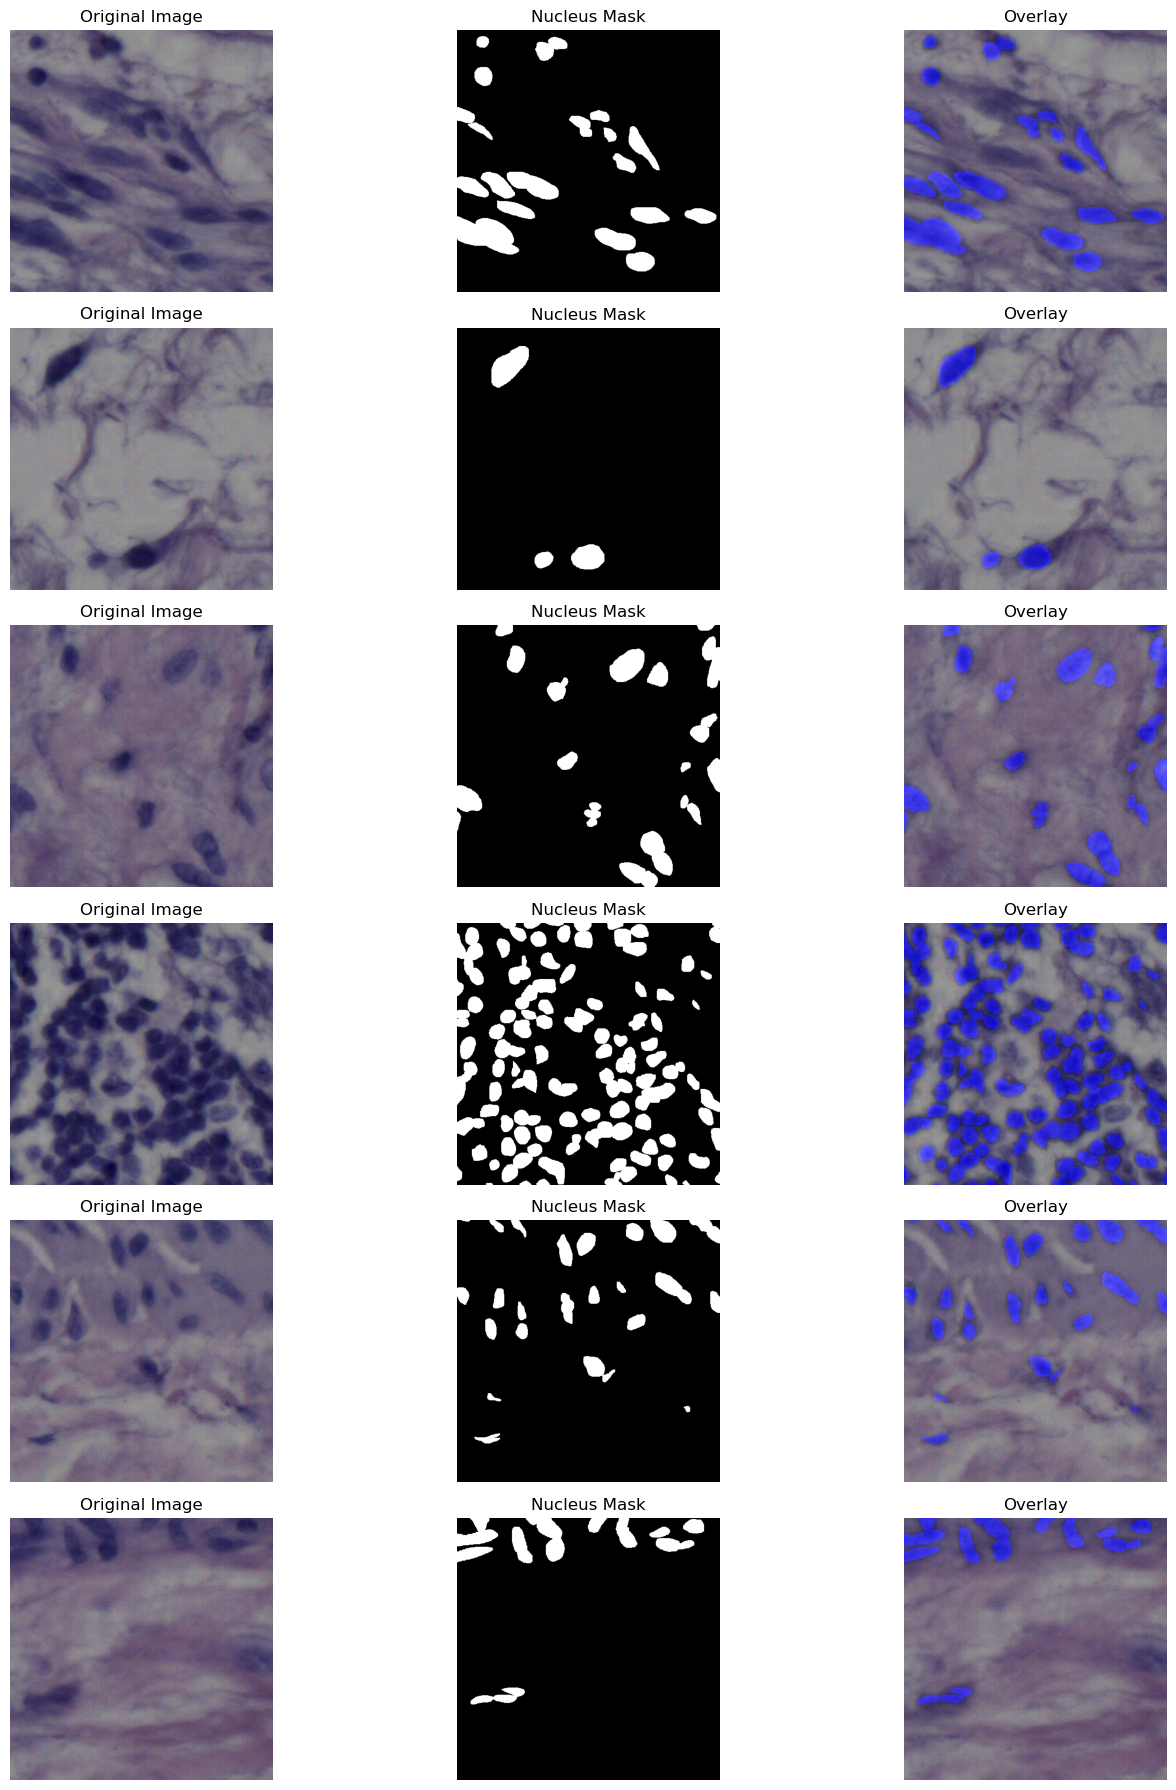

 Preprocessing complete
X shape: (12, 256, 256, 3)
Y shape: (12, 256, 256, 1)


In [2]:
# ================================
#  CONFIGURATION
# ================================

# Set base dataset directory (adjust if needed)
BASE_DIR = "."  # or use full path if notebook is outside the dataset folder
IMAGE_DIR = os.path.join(BASE_DIR, "tissue images")
MASK_DIR = os.path.join(BASE_DIR, "mask binary")  # or "label masks"

# Image size for model input
TARGET_SIZE = (256, 256)

# ================================
#  PREPROCESSING FUNCTIONS
# ================================

def preprocess_image(image, target_size):
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

def preprocess_mask(mask, target_size):
    mask = cv2.resize(mask, target_size)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    mask = mask.astype(np.float32) / 255.0
    mask = np.expand_dims(mask, axis=-1)  # Shape: (H, W, 1)
    return mask

# ================================
#  LOAD, DISPLAY, AND PREPROCESS
# ================================

image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

X = []  # Preprocessed images
Y = []  # Preprocessed masks

num_samples = min(6, len(image_files))  # For visualization
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 3))

for i in range(len(image_files)):
    img_path = os.path.join(IMAGE_DIR, image_files[i])
    mask_path = os.path.join(MASK_DIR, mask_files[i])

    #  Load original image and grayscale mask
    image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    #  Convert to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    #  Display-only section
    if i < num_samples:
        overlay = image_rgb.copy()
        color_mask = np.zeros_like(image_rgb)
        color_mask[:, :, 2] = mask_gray  # red channel
        overlay = cv2.addWeighted(image_rgb, 1, color_mask, 0.5, 0)

        axes[i, 0].imshow(image_rgb)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask_gray, cmap="gray")
        axes[i, 1].set_title("Nucleus Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis("off")

    #  Preprocess and store for training
    image = preprocess_image(image_rgb, TARGET_SIZE)
    mask = preprocess_mask(mask_gray, TARGET_SIZE)

    X.append(image)
    Y.append(mask)

plt.tight_layout()
plt.show()

# Convert lists to arrays
X = np.array(X)
Y = np.array(Y)

print(" Preprocessing complete")
print("X shape:", X.shape)
print("Y shape:", Y.shape)


In [4]:
def generate_low_res_images(X, scale=2):
    low_res = []
    for img in X:
        # Küçült
        small = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_LINEAR)
        # Tekrar büyüt (blur oluşur)
        upscaled = cv2.resize(small, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
        low_res.append(upscaled)
    return np.array(low_res)

low_res_X = generate_low_res_images(X, scale=2)
print("Low-res X shape:", low_res_X.shape)


Low-res X shape: (12, 256, 256, 3)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


In [6]:
from torch.utils.data import Dataset, DataLoader

class SRDataset(Dataset):
    def __init__(self, low_res, high_res):
        self.low_res = torch.tensor(low_res.transpose(0, 3, 1, 2), dtype=torch.float32)
        self.high_res = torch.tensor(high_res.transpose(0, 3, 1, 2), dtype=torch.float32)

    def __len__(self):
        return len(self.low_res)

    def __getitem__(self, idx):
        return self.low_res[idx], self.high_res[idx]

dataset = SRDataset(low_res_X, X)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for lr_imgs, hr_imgs in train_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * lr_imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/20, Loss: 0.2242
Epoch 2/20, Loss: 0.1035
Epoch 3/20, Loss: 0.0171
Epoch 4/20, Loss: 0.0363
Epoch 5/20, Loss: 0.0244
Epoch 6/20, Loss: 0.0081
Epoch 7/20, Loss: 0.0146
Epoch 8/20, Loss: 0.0120
Epoch 9/20, Loss: 0.0047
Epoch 10/20, Loss: 0.0064
Epoch 11/20, Loss: 0.0057
Epoch 12/20, Loss: 0.0044
Epoch 13/20, Loss: 0.0056
Epoch 14/20, Loss: 0.0048
Epoch 15/20, Loss: 0.0033
Epoch 16/20, Loss: 0.0038
Epoch 17/20, Loss: 0.0037
Epoch 18/20, Loss: 0.0032
Epoch 19/20, Loss: 0.0034
Epoch 20/20, Loss: 0.0032


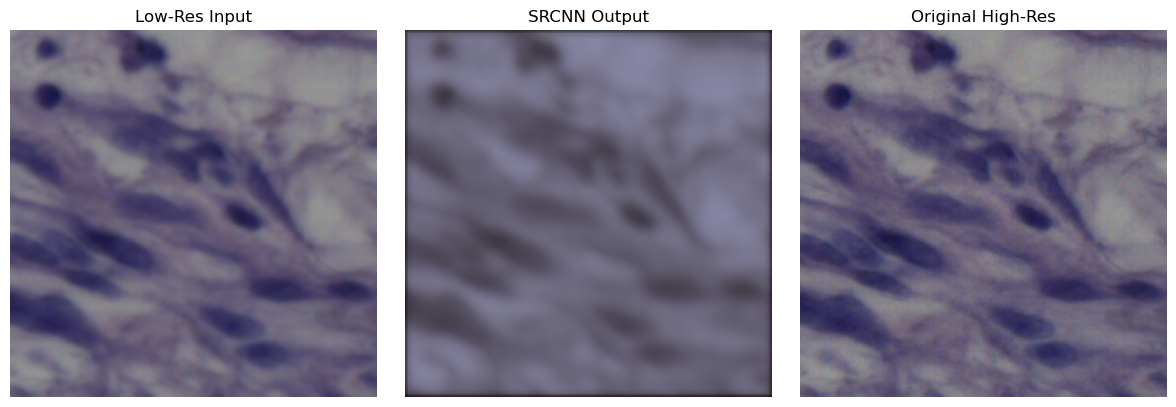

In [8]:
model.eval()
with torch.no_grad():
    sample = torch.tensor(low_res_X[0].transpose(2, 0, 1)).unsqueeze(0).to(device)
    output = model(sample).squeeze(0).cpu().numpy().transpose(1, 2, 0)
    output = np.clip(output, 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Low-Res Input")
    plt.imshow(low_res_X[0])
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("SRCNN Output")
    plt.imshow(output)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Original High-Res")
    plt.imshow(X[0])
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [9]:
sr_outputs = []

model.eval()
with torch.no_grad():
    for img in low_res_X:
        input_tensor = torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0).to(device)
        output = model(input_tensor).squeeze(0).cpu().numpy().transpose(1, 2, 0)
        output = np.clip(output, 0, 1)
        sr_outputs.append(output)

sr_outputs = np.array(sr_outputs)  # Shape: (num_slices, H, W, 3)
print("SR output shape:", sr_outputs.shape)


SR output shape: (12, 256, 256, 3)


In [10]:
from skimage.color import rgb2gray

gray_slices = np.array([rgb2gray(img) for img in sr_outputs])
print("Volume shape:", gray_slices.shape)  # (num_slices, H, W)


Volume shape: (12, 256, 256)


In [13]:
pip install pyvista


     ---------------------------------------- 2.4/2.4 MB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 58.4/58.4 MB 8.2 MB/s eta 0:00:00
     ---------------------------------------- 64.6/64.6 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:

pip install pyvistaqt  # opsiyonel ama daha hızlı arayüz için


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


C:\Users\Zeynep\anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


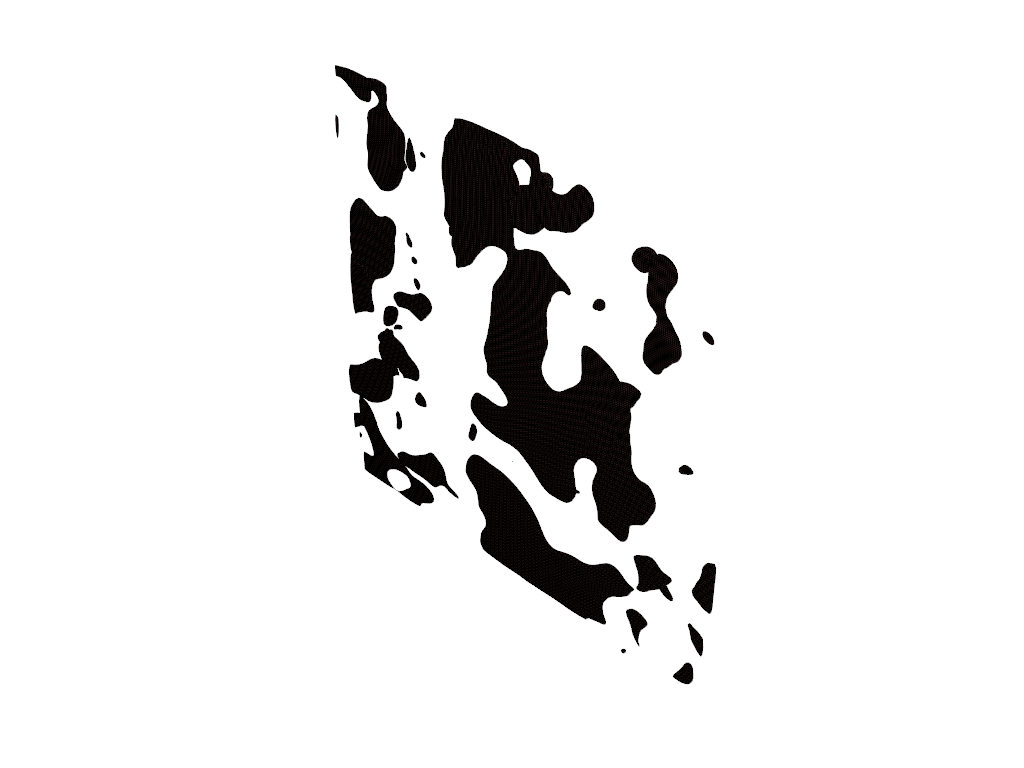

In [15]:
import pyvista as pv
from skimage.measure import marching_cubes

# marching_cubes için (Z, Y, X) formatı
verts, faces, normals, values = marching_cubes(gray_slices, level=0.5)

# Yüzeyleri pyvista'nın istediği formata dönüştür
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int32)  # her üçgen için 3 vertex

# Mesh objesi oluştur
mesh = pv.PolyData(verts, faces_pv)

# Plotla
plotter = pv.Plotter()
plotter.add_mesh(mesh, color="lightcoral", show_edges=True)
plotter.show()


C:\Users\Zeynep\anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


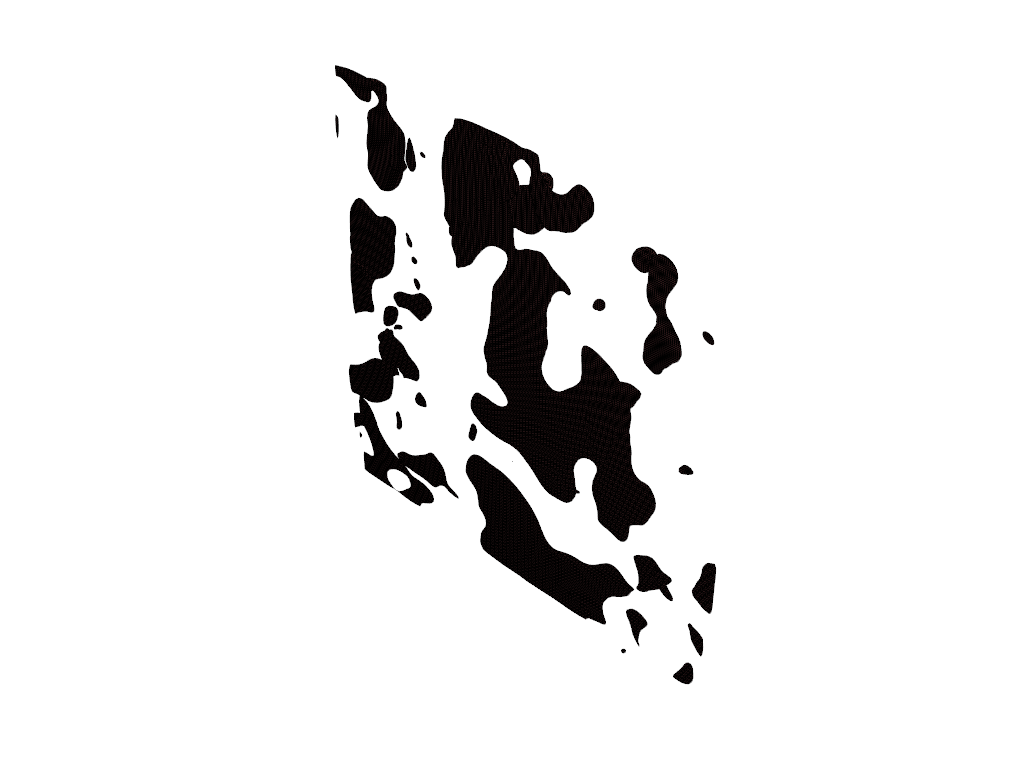

In [16]:
import numpy as np
import pyvista as pv
from skimage.measure import marching_cubes
from skimage.color import rgb2gray

# SRCNN çıktılarından grayscale hacim oluştur
gray_slices = np.array([rgb2gray(img) for img in sr_outputs])  # shape: (num_slices, H, W)

# marching_cubes expects (Z, Y, X) shaped volume
verts, faces, normals, values = marching_cubes(gray_slices, level=0.5)

# PyVista yüzey formatına çevir (her üçgen için başına 3 eklenir)
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3), faces]).astype(np.int32)

# Mesh oluştur
mesh = pv.PolyData(verts, faces_pv)

# Görselleştir
plotter = pv.Plotter()
plotter.add_mesh(mesh, color="lightcoral", show_edges=True)
plotter.show()
